# Neural Network
## MNIST classification problem
* 手寫一個MLP網路用來分類手寫數字
* 用 feedforward propagation 與 backpropagation 來學習NN的參數

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

#### 1.1 Visualizing the data

In [2]:
data = loadmat('data/ex4data1.mat')
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

#### 1.2 Model representation

#### 1.3 Feedforward and cost function

In [3]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(data['y'])
y_onehot.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5000, 10)

In [4]:
data['y'][0], y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

#### 1.4 Regularized cost function

In [5]:
#建構需要的函式

#sigmoid函數
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    a1 = np.insert(X, 0, values=np.ones(m), axis=1) #在X最前面加一列5000*1的向量
    z2 = a1 * theta1.T #得到5000*25的矩陣，400个特徵轉化為25個隱藏特征
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1) #取激活後的z2，再加一列5000*1的向量
    z3 = a2 * theta2.T #得到5000*10的矩陣，最後10個特徵
    h = sigmoid(z3) #激活後得到10個機率
    return a1, z2, a2, z3, h    

def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
    J = J / m
    J += np.sum(first_term - second_term)

    return J

#### 1.5 Random initialization

In [6]:
# initial setup
input_size = 400  #輸入層變數個數400
hidden_size = 25  #隱藏層變數個數為25
num_labels = 10   #輸出層10個代表分別為1到10的概率
learning_rate = 1 #正則化的係數

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) *0.2
m = data['X'].shape[0] 
X = np.matrix(data['X']) #轉為矩陣方便運算
y = np.matrix(data['y'])
# unravel the parameter array into parameter matrices for each layer
##優化得到的行向量按維數合成theta1和theta2
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [7]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

#### 2 Backpropagation
#### 2.1 Sigmoid gradient

In [8]:
#sigmoid函數求導
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))


#### 2.2 Backpropagation

In [9]:
#反向傳播演算法計算梯度的函數，最後得到誤差J和梯度grad（把兩個梯度矩陣按行展開合成一行）
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape) # (25, 401)
    delta2 = np.zeros(theta2.shape) # (10, 26)
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:])) #y_onehot的每一行和輸出概率h的每一行資料相乘
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term) #乘出來的10*1的向量元素求和，再累加5000組的數據

    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:],2)))
    # perform backpropagation          
    for t in range(m):
        a1t = a1[t,:] # (1, 401)
        z2t = z2[t,:] # (1, 25)
        a2t = a2[t,:] # (1, 26)
        ht = h[t,:] # (1, 10)
        yt = y[t,:] # (1, 10)
        d3t = ht - yt # (1, 10)
        z2t = np.insert(z2t, 0, values=np.ones(1)) # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t)) # (1, 26)
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
    delta1 = delta1 / m
    delta2 = delta2 / m
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    return J, grad

In [10]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(6.7451527092154455, (10285,))

#### 2.5 Learning parameters using scipy

In [11]:
%%time
from scipy.optimize import minimize
# minimize the objective function
#用minimize函數通過梯度grad優化J得到最優的theta1和theta2讓J最小
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate),  
                method='TNC', jac=True, options={'maxiter': 250})
fmin

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


Wall time: 4min 48s


     fun: 0.4879830303447946
     jac: array([ 1.08668971e-03,  0.00000000e+00,  0.00000000e+00, ...,
        2.91009681e-04,  4.67899464e-05, -2.61258787e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 16
  status: 3
 success: False
       x: array([-0.11354872,  0.02971812,  0.07273339, ..., -2.62658272,
       -5.16225448,  3.97738811])

In [12]:
X = np.matrix(X)
#優化得到的行向量按維數合成theta1和theta2
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))  
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)   #最優的theta1和theta2正向傳播一次，看看預測下效果
y_pred = np.array(np.argmax(h, axis=1) + 1)  #因為h索引從0開始，需要加1，得到y_pred為我們的預測結果
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [13]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]  #比較預測和實際的結果。正確為1，錯誤為0
accuracy = (sum(map(int, correct)) / float(len(correct))) #累加求和，除以總個數，得到正確率
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 98.28%


#### 3 Visualizing the hidden layer
畫出每個unit偵測到的feature為何，可以幫助我們增進對模型學習結果的判讀與解釋

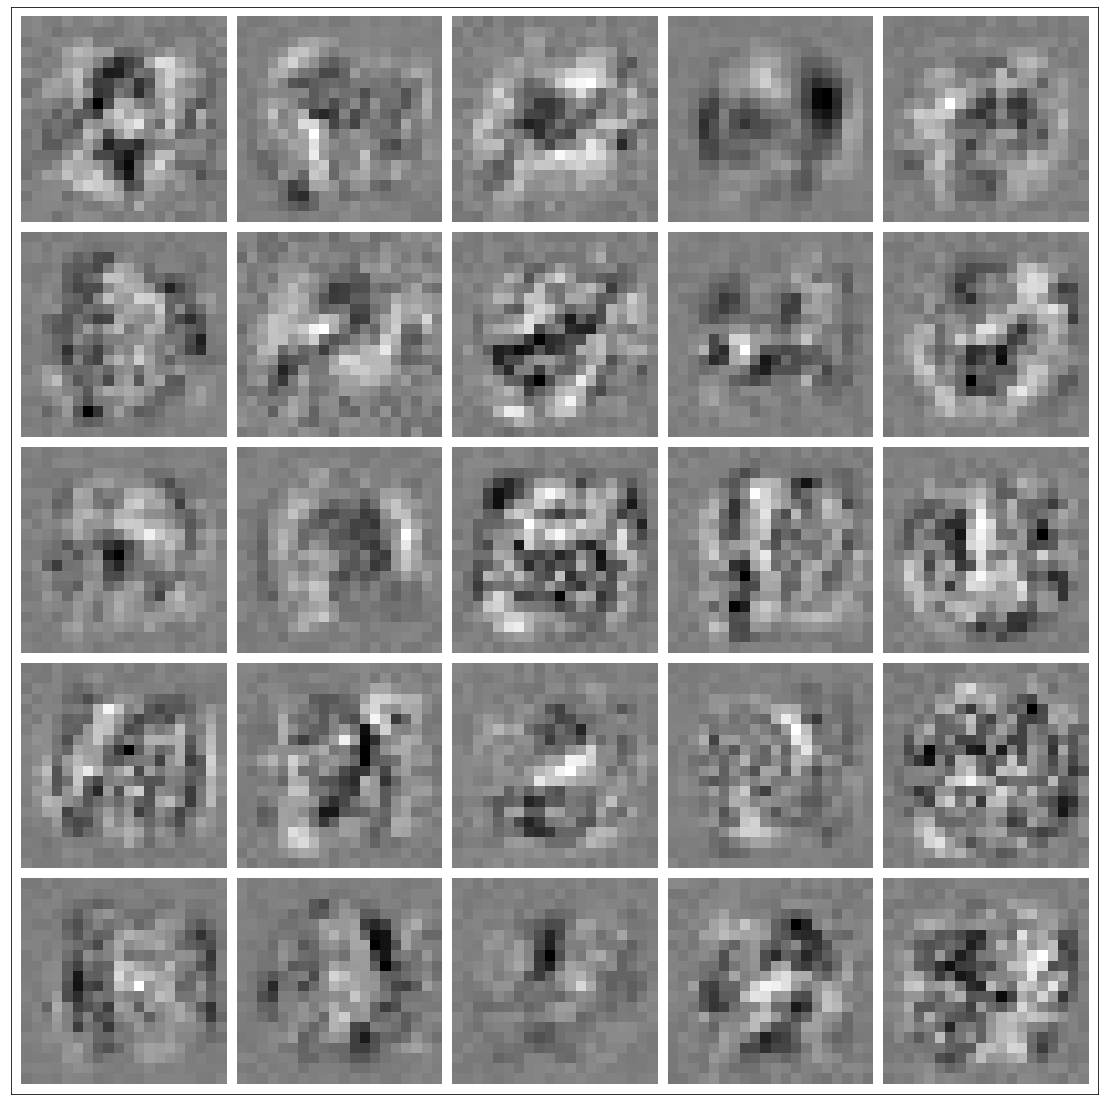

In [14]:
from display_network import *
image = display_network(theta1[:,1:].T)
fig, ax = plt.subplots(figsize = (20, 20))
plt.imshow(image)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

## 問題討論

#### 1.
**這次的程式碼中有一些hyper parameter可以進行調整，  
例如hidden_size 與 learning_rate，  
試討論調參過程與最好的結果，並描述這兩個參數對效能的影響為何。**  

- hidden_size大，模型更複雜，會有更好的學習率
- learning_rate過大可能會造成:
    - 抑制overfitting失敗
    - 造成underfitting
    - 梯度算法不一定收斂

---
#### 2. 
**嘗試以regression任務來解決手寫數字辨識問題，  
並討論與classification任務的效能比較，並解釋其原因。**




